#          Loan origination classification analysis

In [1]:
from IPython.core.display import HTML
import urllib.request
HTML(urllib.request.urlopen('http://bit.ly/1Bf5Hft').read().decode('utf-8'))

In [2]:
import pandas as pd 
import numpy as np
import time

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Machine Learning 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, classification_report

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# Supress warnings
import warnings; warnings.simplefilter('ignore')

#### Table of contents

##### [Introduction](#introduction)

##### [Preprocessing](#preprocessing)

##### [Feature Selection](#dimensionality_reduction)

##### [Training, validation & testing](#training)

##### [Performance comparison](#performance)

##### [Conclusion](#conclusion)


### Introduction <a id='introduction'></a>

Marketplace lending is a way for individual investors to lend money directly to borrowers. The marketplace lending industry seeks to create a market where investors (individuals or institutions) can buy loans directly from the originator, without the need of a banking intermediary. Years of almost-zero rates and ever-stricter banking regulation made it harder and less profitable for banks to give loans, and increasingly necessary for institutional investors to find an alternative to traditional fixed income investments. Marketplace lenders stepped in to fill the gap. A low-cost operating model for marketplace lending platforms allows for lower rates for borrowers as well as solid returns for investors.
<br>
<br>
Prosper and Lending Club are the biggest platforms for marketplace lending in United States. The focus of this report is to examine a specific problem that investors on lending platforms face. We will make use of a loan data set made available by Prosper to analyze this problem. Before we state the problem, it is important to understand how the system of marketplace lending works. We will look at it from two angles: the borrower and the investor.
<br>
<br>
Let’s first look at the borrower. A borrower looking for a loan arrives at a lending website and fills in some personal information (like name, address, yearly salary, employment status, social security number) along with a few details about their loan (principal amount, purpose of loan). The lending platform then runs a soft credit check to see if the borrower is credit-worthy and to calculate the interest rate for the borrower. If the borrower qualifies for the loan, the lending platform gives a rundown of loan terms and interest rates that the borrower qualify for. Once the borrower has okayed the terms, the platform will list the loan online, for investors to pick from. On Prosper, listings stay active for 14 days and investors have to chip in at least 70% of the amount requested. If the loan isn’t funded to at least the 70% mark the listing is cancelled and the borrower needs to start all over again with a new one.
<br>
<br>
Once the loan listing is fully funded, the next step is loan verification. This is a multi-stage process that Prosper uses to verify identity and financial information before releasing the loan proceeds to the borrower. At this point, the borrower needs to submit any documentation that Prosper requests like tax forms, pay stubs or copies of ID. (For the problem which we seek to analyze, this is the most important stage.) After the verification and loan review are complete, the platform wires the full (or partially funded) loan amount to the borrower. The borrower then pays back the loan in equal monthly installments until it’s paid in full. The payments go through the platform directly to the investor.
<br>
<br>
Now let's look at the investor side. Lending platforms release in periodic batches, the data on all pre-approved loans. (We use one such dataset released by Prosper for this project.) The investors choose which loans they would want to invest in. Investors need to invest a minimum of 25$ in any individual loan. Diversification is a natural outcome because investors can invest small amounts into hundreds or thousands of borrowers. A well-diversified portfolio can minimize the risk of loss. To generate good returns, an investor must be able to separate the good notes from the bad. Second, having access to the loans – snatching them up first – is another key to achieving good results. 
<br>
<br>
This project broadly deals with the first issue, seperating good notes from the bad. Recall that marketplace lenders list customers’ loans for funding without verifying their information. If a loan is successfully funded, they are asked for additional documentation. The loan is originated only if the comply, otherwise it is cancelled. A cancelled loan results in investors getting their capital back.  Loan cancellations hurt investors' returns, since they add a few days of cash drag: the money they put towards them could have instead been deployed to other loans. As investors, we also need to think of chances of default for successfully originated loans and how to allocate capital to achieve good returns, but that is not the primary focus of our analysis.   
<br>
*The specific aim of this project is to predict whether a loan will be successfully originated or not.*
<br>
<br>
Let's dive in and load the data!


In [3]:
df =  pd.read_csv('new_theorem_data.csv')
pd.set_option("display.max_columns", len(df.columns))
df.head(10)

,ListingNumber,ListingID,DateCreditPulled,DateListingStart,DateListingCreation,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,StrState,StrBorrowerCity,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,NumPriorProsperLoans31dpd,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,DateFirstCredit,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan
0,973605,973605,2013-10-13 01:50:58,2014-01-26 19:00:08.887000,2013-10-13 01:50:56.287000,7,15000.0,True,B,0.1520,0.1620,60,366.37,689,6.0,1,6000.0000,True,0.27,Employed,Tradesman - Mechanic,445.0,VA,VIRGINIA BCH,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,70000,29,1,0,0,0,0,121431,0,1348,419,0,96,4,439,0,2,4,33956,0,1242,0,1,0,0,1978-11-03 08:00:00,35,0,0,11,8,0.97,7,87475,52941,583,5,33,2,8,1,True,3,2014-01-26 18:28:42.477000,NaN,True,False
1,981099,981099,2013-10-15 15:22:06,2014-01-10 00:00:16.530000,2013-10-15 15:22:03.990000,7,15000.0,True,B,0.1485,0.1585,60,363.58,709,8.0,1,7916.6667,True,0.35,Other,NaN,32.0,CA,ACTON,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,70000,50,1,0,0,0,0,698295,0,4845,430,0,100,7,9609,142383,2,4,14852,0,2289,0,0,0,0,1977-12-01 08:00:00,54,0,0,15,14,0.48,10,541060,17064,2611,3,53,1,2,1,True,2,2014-01-09 23:49:48.150000,NaN,True,False
2,1025766,1025766,2013-11-06 23:09:36,2014-01-22 01:00:30.420000,2013-11-06 23:09:33.137000,6,4000.0,True,D,0.1985,0.2085,36,150.39,669,6.0,1,2083.3333,True,0.53,Employed,Professional,4.0,MN,MINNEAPOLIS,1,3,14400.0,4440.72,4442.52,52.0,52.0,0.0,0.0,8000.0,1400.0,10.0,NaN,NaN,0,False,80000,15,0,0,0,0,1,30590,0,901,100,2,86,5,1498,9788,0,0,20802,1,911,0,2,0,0,2005-07-19 07:00:00,17,2,0,8,7,0.93,5,0,20802,0,5,15,2,3,2,False,1,NaN,NaN,False,True
3,1003835,1003835,2013-11-08 02:25:29,2014-01-03 00:00:09.013000,2013-11-08 02:25:27.187000,7,10000.0,True,A,0.1199,0.1299,36,336.89,749,5.0,13,3750.0000,True,0.14,Employed,Medical Technician,2.0,OK,OKLAHOMA CITY,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,90000,8,1,0,0,0,0,3100,0,223,60,0,100,3,6050,0,0,0,3100,0,223,0,0,0,0,2008-11-04 08:00:00,8,0,0,7,7,0.26,7,0,3100,0,1,8,0,0,0,False,3,2014-01-02 23:47:33.943000,NaN,True,False
4,1011335,1011335,2013-11-11 22:08:44,2014-01-10 01:02:19.547000,2013-11-11 22:08:41.660000,6,20000.0,True,B,0.1340,0.1440,60,469.52,649,11.0,1,9000.0000,True,0.16,Employed,Executive,90.0,MN,BELLE PLAINE,0,1,2600.0,0.00,0.00,33.0,31.0,2.0,0.0,2600.0,2600.0,34.0,NaN,NaN,0,False,80000,30,1,0,0,0,1,378

In [4]:
# List the features and look for missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252469 entries, 0 to 252468
Data columns (total 87 columns):
ListingNumber                               252469 non-null int64
ListingID                                   252469 non-null int64
DateCreditPulled                            252469 non-null object
DateListingStart                            252469 non-null object
DateListingCreation                         252469 non-null object
EnumListingStatus                           252469 non-null int64
DolLoanAmountRequested                      252469 non-null float64
BoolPartialFundingApproved                  252469 non-null bool
CreditGrade                                 252469 non-null object
LenderYield                                 252469 non-null float64
BorrowerRate                                252469 non-null float64
NumMonthsTerm                               252469 non-null int64
DolMonthlyLoanPayment                       252469 non-null float64
FICOScore           

The dataset has 86 features and one label.  Our target variable is `EnumListingStatus`: It is 6 if a loan was originated, or 7 if it was cancelled. The dataset contains a mixture of numeric, ordinal and categorical variables. We will build a model to predict the label and set up an experiment to validate its performance using ROC AUC. 
<br>
<br>
Before we start, let's look at label distribution, as this will tell us if our dataset labels are evenly split or biased in favor of one class.

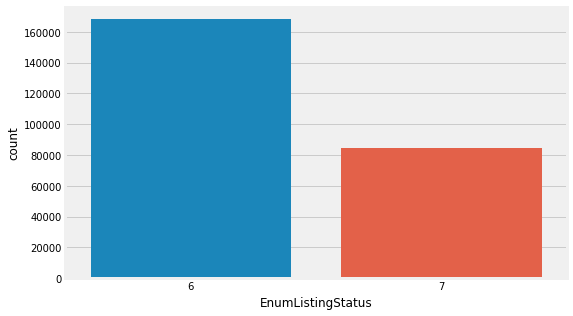

In [5]:
f, ax = plt.subplots(figsize=(8, 5))
sns.countplot(df["EnumListingStatus"])

About 2/3rd of the listings eventually got approved. We see a definite bias in favor of originated loans, although the skewness is not heavy. 

It is always a good practice to provide a description of the features, as that helps in understanding the problem domain better. 

| Feature                                         |                 Description   |
|---------------------------------------------------|-------------------------------|
|*ListingNumber*                                    | The number that uniquely identifies the listing to the public as displayed on the Prosper website                                                   | 
|*ListingID*                                        | Same as *ListingNumber*|
|*DateCreditPulled*                                 | The date the credit profile was pulled (Soft check)|
|*DateListingStart*                                 | The date the listing starts|
|*DateListingCreation*                              | The date the listing was created|
|*DolLoanAmountRequested*                           | Loan amount requested by the borrower|
|*BoolPartialFundingApproved*                       | Whether a partial funding option was offered to the borrower|
|*CreditGrade*                                      | Each loan gets a credit grade, AA, A, B, C, D, E or HR for high risk. The higher the letter, the higher the corresponding risk|
|*LenderYield*                                      |Lender yield on the loan. Lender yield is equal to the interest rate on the loan minus the servicing fee|
|*BorrowerRate*                                     | Borrower’s interest rate for this loan|
|*NumMonthsTerm*                                    | The loan duration. Either 36 months or 60 months|
|*DolMonthlyLoanPayment*                            | Monthly payment on the loan|
|*FICOScore*|   Fico credit scores. On Prosper, the lowest FICO score allowed is 640|
|*ProsperScore*| A custom risk score built using historical Prosper data. The score ranges from 1-11, with 11 being the best, or lowest risk score|
|*DolMonthlyIncome*| Monthly stated income of the borrower|
|*BoolIncomeVerifiable*| Whether the stated income is verifiable or not|
|*FracDebtToIncomeRatio*| The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. The maximum debt-to-income ratio for all applicants is 50%|
|*StrEmploymentStatus*| Empolyment status. Is one among 'Employed', 'Self-Employed', 'Full-time', 'Part-time', 'Not-Employed'|
|*StrOccupation*| Stated occupation of the borrower|
|*NumMonthsEmployed*| The length in months of the employment status at the time the listing was created|
|*StrState*| The two letter abbreviation of the state  of the address of the borrower at the time the listing was created|
|*StrBorrowerCity*| Borrower city of address|
|*NumPriorProsperLoansActive*| Number of prior Prosper Loans still active|
|*NumPriorProsperLoans*| Total number of prior Prosper loans|
|*DolPriorProsperLoansPrincipalBorrowed*| Total principal amount borrowed on prior Prosper loans. Is null if the borrower has no prior history with Prosper|
|*DolPriorProsperLoansPrincipalOutstanding*| Prosper principal balance outstanding at the time of listing creation. Is null if the borrower has no prior history with Prosper|
|*DolPriorProsperLoansBalanceOutstanding*| Prosper loan balance outstanding at the time of listing creation. Is null if the borrower has no prior history with Prosper|
|*NumPriorProsperLoansCyclesBilled*| Total Prosper payments billed prior to listing creation. Is null if the borrower has no prior history with Prosper|
|*NumPriorProsperLoansOnTimePayments*| Number of Prosper payments paid on time. Is null if the borrower has no prior history with Prosper|
|*NumPriorProsperLoansLateCycles*| Number of prior Prosper loans late cycles|
|*NumPriorProsperLoansLatePayments*| Number of prior Prosper loans not paid on time. Is null if the borrower has no prior history with Prosper|
|*DolMaxPriorProsperLoan*| Maximum amount of prior Prosper loan borrowed. Is null if the borrower has no prior history with Prosper|
|*DolMinPriorProsperLoan*| Maximum amount of prior Prosper loan borrowed. Is null if the borrower has no prior history with Prosper|
|*NumPriorProsperLoansEarliestPayOff*| Number of prior Prosper loans paid off before the expiry of term |
|*NumPriorProsperLoans31dpd*| Number of prior Prosper loans 31 days past due|
|*NumPriorProsperLoans61dpd*| Number of prior Prosper loans 61 days past due|
|*BoolIsLender*| Is the Borrower a lender|
|*BoolInGroup*| Specifies whether or not the Borrower was in a group at the time the listing was created|
|*EnumChannelCode*| A numerical value indicating the acquisition channel from which the borrower was sourced. 5 different acquisition channels by the following codes: 40000, 50000, 70000, 80000, and 90000|
|*NumTrades*| Total Number of Trades (accounts)|
|*NumTradesOpened6*| Number of trades opened in the last 6 months|
|*NumTradesDelinqOrPastDue6*| Number of trades delinquent or past due in the last 6 months|
|*NumOpenTradesDelinqOrPastDue6*| Number of open trades delinquent or past due in the last 6 months|
|*NumTradesCurr30DPDOrDerog6*| Number of trades currently 30 days past due or derogatory within the past 6 months|
|*NumTradesCurr90DPDOrDerog6*| Number of trades currently 90 days past due or derogatory within the past 6 months|
|*DolTotalBalanceAllOpenTrades6*| Total balance in the last 6 months on all open trades|
|*DolTotalBalanceOnPublicRecords*| Total balance on pubic records| 
|*DolTotalPaymentAllOpenTrades6*| Total payment within the las 6 months on all open trades|
|*AgeOldestTrade*| Number of months since the oldest trade was opened|
|*NumInquiries6MinusLastTwoWeeks*| Number of credit inquries in the past 6 months (excluding the last 14 days)|
|*NumInquiries6*| The number of times a bank or other business has requested the borrower’s credit profile from a consumer credit rating agency in the last 6 months|
|*PctTradesNeverDelinquent*| Percentage of trades never delinquent|
|*NumBankcardTradesOpened12*| Number of bank trades opened in the last 12 months|
|*DolTotalAvailBankcardCredit6*| Total available credit on bankcard trades |
|*DolTotalBalanceInstallTradesReptd6*| Total balance on installation trades in the past 6 months|
|*NumRealEstateTrades*| Total number of real estate trades|
|*NumRealPropertyTrades*| Total number of property trades|
|*DolTotalBalanceOpenRevolving6*| The total outstanding balance that the borrower owes on open credit cards or other revolving credit accounts in the last 6 months|
|*NumTradesEverDerog*| Total number of trades ever derogatory|
|*DolMonthlyDebt*| Monthly debt|
|*NumCurrentDelinquencies*| Number of current deliquencies|
|*NumDelinquencies84*| Number of delinquencies in the past 7 years|
|*NumPublicRecordsLast10Years*| Number of public records in the last 10 years|
|*NumPublicRecords12*| Number of public records in the last 12 months. Public records include bankruptcies, liens and judgments|
|*DateFirstCredit*| Date the first credit was opened|
|*NumCreditLines84*| Number of credit lines in the last 7 years|
|*DolAmountDelinquent*| Amount delinquent|
|*NumOpenCreditLines*| Number of open credit lines|
|*NumCurrentCreditLines*| Number of current credit lines|
|*PctBankcardUtil*| A percentage value determined by the sum of the balances owed on open bankcards divided by the sum of the cards’ credit limits|
|*NumOpenRevolvingAccounts*| The total number of open revolving credit lines a borrower has|
|*DolRealEstateBalance*| Balance on real estate trades|
|*DolRevolvingBalance*| The total outstanding balance that the borrower owes on open credit cards or other revolving credit accounts|
|*DolRealEstatePayment*| Payment amount of real estate trades|
|*NumTotalInquiries*| The number of times a bank or other business has requested the borrower’s credit profile from a consumer credit rating agency| 
|*NumDelinquenciesOver30Days*| Number of delinquencies over 30 days|
|*NumDelinquenciesOver60Days*| Number of delinquencies over 60 days|
|*NumSatisfactoryAccounts*| Number of satisfactory accounts|
|*NumWasDelinquentDerog*| Number of accounts that have been reported delinquent/derogatory|
|*BoolOwnsHome*| Whether the borrower owns a home|
|*EnumLoanFractionalType*| |
|*DateWholeLoanStart*| Date the listing was posted to the whole loan pool|
|*DateWholeLoanEnd*| Date the listing was moved from the whole loan pool to the fractional loan pool|
|*BoolEverWholeLoan*| Was the listing ever in the whole loan pool|
|*BoolIsFractionalLoan*| Has the listing moved to fractional pool|
                                                 

A quick look at the data reveals the following.
<br>
<br>
1) Some features are administrative identifiers (e.g. ListingID and ListingNumber). They won't be of any use in our prediction task. 
<br>
2) Features have a wide variety of ranges. Some are numeric, some are boolean while some are categorical.  We will need to re-scale them to make them more amenable to some of our classification algorithms. 
<br>
3) There are 11 variables of type object, with most of them referring to some date. Those will probably need some attention before they're ready for some of our classification models.
<br>
4) Some variables have a lot of null values, specifically a lot of variables associated with the Prosper history of the borrower. 


### Data Preprocessing <a id='preprocessing'></a>

Let's begin by pre-preprocessing the data by removing extraneous features and taking care of missing values. 
<br>
<br>
##### Features of the type 'Object'

Lets start by considering the features of the type 'object'. 


In [7]:
object_features = df.select_dtypes(include=["object"]).columns.values
object_features
df[object_features].head(10)

,DateCreditPulled,DateListingStart,DateListingCreation,CreditGrade,StrEmploymentStatus,StrOccupation,StrState,StrBorrowerCity,DateFirstCredit,DateWholeLoanStart,DateWholeLoanEnd
0,2013-10-13 01:50:58,2014-01-26 19:00:08.887000,2013-10-13 01:50:56.287000,B,Employed,Tradesman - Mechanic,VA,VIRGINIA BCH,1978-11-03 08:00:00,2014-01-26 18:28:42.477000,NaN
1,2013-10-15 15:22:06,2014-01-10 00:00:16.530000,2013-10-15 15:22:03.990000,B,Other,NaN,CA,ACTON,1977-12-01 08:00:00,2014-01-09 23:49:48.150000,NaN
2,2013-11-06 23:09:36,2014-01-22 01:00:30.420000,2013-11-06 23:09:33.137000,D,Employed,Professional,MN,MINNEAPOLIS,2005-07-19 07:00:00,NaN,NaN
3,2013-11-08 02:25:29,2014-01-03 00:00:09.013000,2013-11-08 02:25:27.187000,A,Employed,Medical Technician,OK,OKLAHOMA CITY,2008-11-04 08:00:00,2014-01-02 23:47:33.943000,NaN
4,2013-11-11 22:08:44,2014-01-10 01:02:19.547000,2013-11-11 22:08:41.660000,B,Employed,Executive,MN,BELLE PLAINE,1994-02-04 08:00:00,NaN,NaN
5,2013-11-11 17:57:36,2014-01-09 16:00:25.610000,2013-11-11 17:57:33.190000,D,Employed,Professional,AL,MONTGOMERY,1986-09-01 07:00:00,2014-01-09 15:50:28.617000,NaN
6,2013-11-11 13:54:40,2014-01-02 16:00:25.513000,2013-11-11 13:54:37.193000,AA,Self-employed,Food Service,FL,MARY ESTHER,1986-10-03 07:00:00,2014-01-02 15:30:27.903000,NaN
7,2013-11-13 00:25:25,2014-01-02 16:00:14.767000,2013-11-13 00:25:23.517000,AA,Employed,Retail Management,NY,STATEN ISLAND,2006-04-11 07:00:00,2014-01-02 15:30:28.487000,NaN
8,2013-11-11 15:25:22,2014-01-09 16:00:12.007000,2013-11-11 15:25:17.693000,B,Employed,Other,VA,HERNDON,1990-10-05 07:00:00,2014-01-09 15:50:28.880000,NaN
9,2013-11-11 23:34:31,2014-01-26 20:00:31.670000,2013-04-03 21:51:20.923000,B,Employed,Pharmacist,VA,CULPEPER,1984-03-01 08:00:00,NaN,NaN


Let's see if we can't quickly get rid of some extraneous information by dropping redundant or irrelevant columns from the dataset.
<br>
<br>
We observe that `DateCreditPulled` almost immediately follows `DateListingCreation`, as expected.  For the purpose of classification of whether a loan will be originated, the date the listing was created or made available to the public, the date the credit was pulled and the date of first credit shouldn't really matter. (It might perhaps be of interest to observe the difference in days between the time a listing was created and the time when the listing started i.e was made available to the investors. This might potentially give us an an idea of how marketplace lending has evolved with time. As marketplace lending becomes more efficient, this delay should be shorter.) For purpose of loan origination classification, these features won't be of much help and we will remove them. 
<br>
<br>
The length of credit history could potentially be a powerful feature so I'd like to keep this. Let's try turning this variable into a "MonthsWithCredit" variable that will take continuous integer values rather than being a datetime object. 

In [8]:
df['MonthsWithCredit'] = (pd.to_datetime(df.DateCreditPulled) -  pd.to_datetime(df.DateFirstCredit)).astype('timedelta64[M]')

In [9]:
df.drop(["DateCreditPulled", "DateListingStart", "DateListingCreation", 'DateFirstCredit'], axis=1, inplace=True) 

`DateWholeLoanStart` indicates the date the listing was posted to the whole loan pool (where a handful of loans are randomly selected and offered to institutional investors prior to public release) and `DateWholeLoanEnd` indicates the date
 the listing was moved from the whole loan pool to the fractional loan pool.  
<br>
We notice that there are exactly 6491 non-null entries in the `DateWholeLoanEnd` columns. These should correspond to entries which were moved from whole loan pool to fractional loan pool. Let us quickly check that 

In [10]:
(df[df.DateWholeLoanEnd.notnull()].index == df[df.BoolIsFractionalLoan & df.BoolEverWholeLoan].index).sum()

6491

We also observe that `DateWholeLoanEnd` has very few non null entries (~3%). Moreover, both `DateWholeLoanStart` and `DateWholeLoanEnd` are timestamps that don't really give us any predictive power, and hence it is reasonable to drop remove features.  

In [11]:
df.drop(["DateWholeLoanStart", "DateWholeLoanEnd"], axis=1, inplace=True) 

Borrower City could be very interesting (we can perhaps look at historical rates of defualt and group them by cities or geographical region and get some sort of heatmap), but being such a broad categorical variable it would be incredibly difficult to use. Let's drop this column. 

In [12]:
df.drop(["StrBorrowerCity"], axis=1, inplace=True)

Let us now turn to occupation.  

In [13]:
df.StrOccupation.unique()

array(['Tradesman - Mechanic', nan, 'Professional', 'Medical Technician',
       'Executive', 'Food Service', 'Retail Management', 'Other',
       'Pharmacist', 'Attorney', 'Food Service Management',
       'Sales - Retail', 'Civil Service', 'Professor', 'Nurse (RN)',
       'Analyst', 'Computer Programmer', 'Military Enlisted',
       'Police Officer/Correction Officer', 'Truck Driver', 'Doctor',
       'Landscaping', 'Skilled Labor', 'Administrative Assistant',
       'Nurse (LPN)', 'Engineer - Mechanical', 'Accountant/CPA',
       'Construction', 'Teacher', 'Clerical', 'Principal', 'Dentist',
       'Laborer', 'Engineer - Electrical', 'Sales - Commission',
       "Teacher's Aide", 'Postal Service', 'Fireman', 'Social Worker',
       'Chemist', 'Psychologist', 'Tradesman - Electrician',
       'Pilot - Private/Commercial', 'Realtor', 'Waiter/Waitress',
       'Bus Driver', 'Scientist', "Nurse's Aide", 'Car Dealer',
       'Architect', 'Student - College Graduate Student', 'Homemaker'

Occupation could be very promising, but being such a broad categorical variable it would be very challenging to use. Group affiliation could be a potential line of inquiry, and that this line of inquiry is perhaps left best to another investigation into Prosper's grouping practice. 

In [14]:
df.drop(["StrOccupation"], axis=1, inplace=True)

There are two administrative variables `ListingNumber` and `ListingID`. These are unique identifiers associated with a listing on Prosper, and are clearly redundant. Let's remove these columns. 

In [15]:
df.drop(["ListingNumber", "ListingID"], axis=1, inplace=True)

##### Imputation of missing values 

Let us now focus our attention on variables which have missing values.
<br>
Some features associated with Prosper history of 
debtor have lots of NaNs. Let's first take a look at these features. 

In [16]:
prosper_history_vars = ['DolPriorProsperLoansPrincipalBorrowed', 
                        'DolPriorProsperLoansPrincipalOutstanding',    
                        'DolPriorProsperLoansBalanceOutstanding', 
                        'NumPriorProsperLoansCyclesBilled',           
                        'NumPriorProsperLoansOnTimePayments', 
                        'NumPriorProsperLoansLateCycles', 
                        'NumPriorProsperLoansLatePayments',
                        'DolMaxPriorProsperLoan', 
                        'DolMinPriorProsperLoan',
                        'NumPriorProsperLoansEarliestPayOff']

A lot of these features intuitively must be closely related. For instance, Prosper principal balance outstanding and outstanding loan balance must be similar (they should be same minus the borrower interest rate), number of prior Prosper loan cycles billed must be closely related to number of prior Prosper on time payments. Let's draw a heatmap of the correlation between these features to visualize their linear dependence.

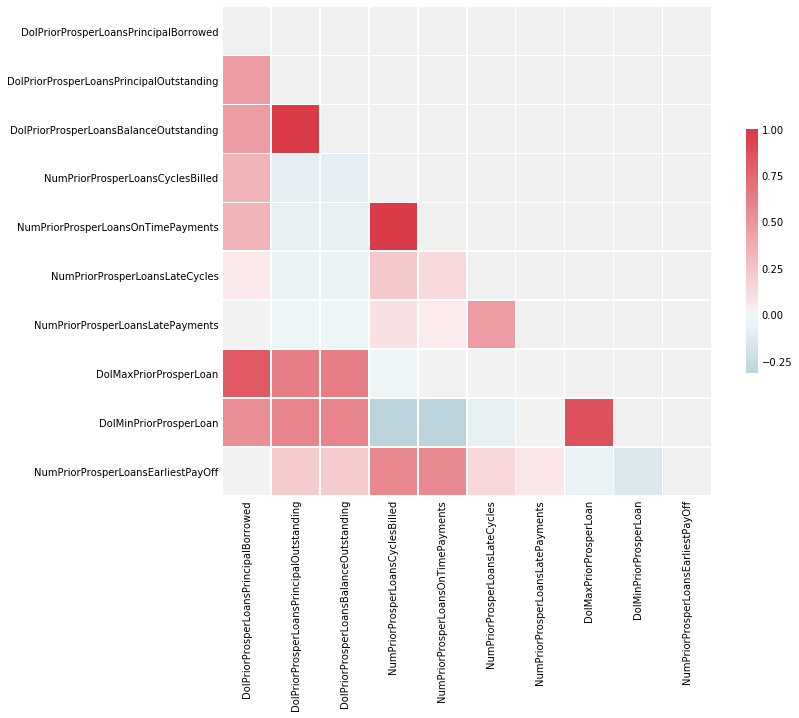

In [17]:
# Compute the correlation matrix
prosper_history_corr = df[prosper_history_vars].corr()

mask = np.zeros_like(prosper_history_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(prosper_history_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
# prosper_corr

Note that most of `prosper_variables` features have lots of null values and it can be tempting to remove them altogether. However, prior Prosper history of debtors should have an impact on pricing of a loan. Null values within these columns indicates a lack of history with Prosper. We can fill these columns with 0s to represent a lack of such history. 

In [19]:
df[prosper_history_vars] = df[prosper_history_vars].fillna(0) # Impute with 0

There are 2 more variables associatated wih Prosper history of the debtor, `NumPriorProsperLoans31dpd` and `NumPriorProsperLoans61dpd`. Both these features could be very important as delay in payment of prior Prosper loans would result in a higher interest rate or could negatively impact the chance of a future loan being originated. We could fill these columns with 0s to represent a lack of history, but these features have less than 0.1% of non null values and imputing with 0's would not really help as the features will end up being mostly constant, and would fail to have any influence on a classification algorithm. Let's remove these two columns. 

In [20]:
df.drop(["NumPriorProsperLoans31dpd", "NumPriorProsperLoans61dpd"], axis=1, inplace=True)

There are still 3 columns with missing values. `FracDebtToIncomeRatio`, `NumMonthsEmployed` and `ProsperScore`. Let's investigate these features. 

As indicated in [Prosper API](https://developers.prosper.com/docs/investor/listings-api/), `ProsperScore` is custom risk score built using historical Prosper data. The score ranges from 1-11, with 11 being the best, or lowest risk score. Let's do a sanity check to ensure that all non null entries have a Prosper score not greater than 11. 

In [21]:
wrong_pros_score_index = df[df.ProsperScore > 11].index
df = df.drop(df.index[wrong_pros_score_index])

There is an entry with Prosper Score of 21. This is most likely an error. I removed this entry altogether. 

A few missing entries under `ProsperScore` remain. We could remove these entries or fill them out with arbitrary values. Let's fill them with median values.

In [22]:
df["ProsperScore"].fillna(df["ProsperScore"].median(), inplace=True)

Let's now focus on entries under `NumMonthsEmployed` which have missing values. 

In [23]:
df[df.NumMonthsEmployed.isnull()]

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit
8292,7,2000.0,False,A,0.10890,0.1189,36,66.32,769,2.0,7,4166.6667,False,NaN,Self-employed,NaN,NY,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,50000,13,0,0,0,0,0,2198,0,84,74,1,100,4,22802,0,0,0,2198,0,84,0,0,0,0,13,1,0,10,7,0.08,7,0,2198,0,7,13,0,0,0,False,2,True,False,74.0
19902,7,15000.0,True,B,0.12850,0.1385,36,511.57,749,2.0,1,7083.3333,False,0.42,Self-employed,NaN,VT,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,44,1,0,0,0,0,436895,0,3808,286,0,100,8,27565,32680,4,4,159036,0,2291,0,0,0,0,44,0,0,13,12,0.85,9,245179,159036,1517,8,44,0,0,0,True,3,True,False,285.0
81714,7,15000.0,True,C,0.15050,0.1605,60,365.17,709,7.0,2,0.0000,False,0.30,Not employed,NaN,NC,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,40000,35,1,0,0,0,0,37956,0,1239,444,1,100,9,18955,18411,1,5,19545,0,1259,0,0,0,0,38,1,0,15,14,0.50,14,148173,19545,1512,11,37,1,1,2,True,3,True,False,443.0
108010,6,27000.0,True,A,0.10990,0.1199,36,896.66,729,3.0,1,22333.3333,False,0.40,Self-employed,NaN,VA,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,90000,21,1,0,0,0,0,420189,0,3753,227,1,100,7,5706,52003,3,3,23495,0,1610,0,0,0,0,22,1,0,12,12,0.78,8,344691,23495,2143,3,22,0,0,0,True,3,True,False,227.0
120235,6,5000.0,True,B,0.12050,0.1305,36,168.59,669,5.0,1,10000.0000,False,NaN,Self-employed,NaN,CA,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,40000,12,1,0,0,0,0,24636,0,741,88,2,100,6,7457,12014,0,0,12622,0,741,0,0,0,0,13,2,0,9,9,0.61,8,0,12622,0,14,13,0,0,0,False,3,True,False,88.0
135943,7,35000.0,True,A,0.10990,0.1199,36,1162.33,749,5.0,1,11666.6667,False,0.24,Self-employed,NaN,NJ,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,90000,38,0,0,0,0,0,488512,0,4575,400,0,100,16,80719,0,5,9,126407,0,1636,0,0,0,0,44,0,0,28,28,0.60,26,362105,126407,2939,3,44,0,0,0,True,3,True,False,400.0
140646,6,2000.0,False,E,0.23240,0.2424,36,78.72,669,3.0,1,3000.0000,False,NaN,Employed,NaN,VA,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,40000,7,1,0,0,0,0,149,0,35,168,0,85,2,2952,0,0,0,149,0,170,1,0,0,0,11,0,305,3,3,0.04,4,0,6904,0,0,9,1,3,0,False,3,True,False,167.0
154080,7,14600.0,True,C,0.14700,0.1570,60,352.72,669,6.0,1,6666.6667,True,0.16,Employed,NaN,CA,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,40000,20,1,0,0,0,0,28411,0,714,183,0,100,6,3495,12476,0,0,159

18 entries have missing values under `NumMonthsEmployed`. Most of them are self-employed and some of them are not employed. Some have verifiable income and some do not. There is no clear discernible pattern here. Let's impute these entries with `MonthsWithCredit` values, which should be an upper bound on possible number of months of employment.

In [24]:
df["NumMonthsEmployed"].fillna(df["MonthsWithCredit"], inplace=True)

We will now turn our attention to entries with missing `FracDebtToIncomeRatio` values.

In [25]:
df[df['FracDebtToIncomeRatio'].isnull()].head(10)

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit
6,6,15000.0,True,AA,0.0709,0.0809,36,470.67,689,11.0,3,6250.0000,False,NaN,Self-employed,9.0,FL,0,1,4000.0,0.0,0.0,10.0,10.0,0.0,0.0,4000.0,4000.0,11.0,1,False,80000,33,1,0,0,0,3,147525,0,2193,325,2,87,3,9000,41365,2,6,0,3,1488,0,2,1,0,36,2,0,9,8,0.00,5,106160,0,705,8,30,6,4,5,True,3,True,False,325.0
21,7,4000.0,True,D,0.2204,0.2304,36,154.92,689,3.0,3,1833.3333,False,NaN,Self-employed,259.0,WI,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,40000,9,0,0,0,0,0,4403,0,220,197,0,88,4,2742,0,1,3,4403,0,220,0,0,1,0,15,0,0,6,6,0.56,6,0,4403,0,1,13,2,5,2,False,1,False,True,197.0
44,6,8000.0,True,D,0.1980,0.2080,60,215.53,649,4.0,1,11166.6667,False,NaN,Self-employed,45.0,CO,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,18,1,0,0,0,1,38551,0,900,213,0,94,5,4588,30930,0,0,7621,1,1099,0,3,1,0,25,0,0,11,11,0.59,7,0,7621,0,5,22,3,1,1,False,2,True,False,213.0
48,6,15000.0,True,C,0.1665,0.1765,36,539.66,749,2.0,3,10000.0000,False,NaN,Self-employed,104.0,CA,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,17,0,0,0,0,0,18462,0,727,140,2,100,3,15440,902,0,0,17560,0,912,0,0,0,0,17,2,0,7,4,0.53,4,0,20945,0,5,17,0,0,0,False,3,True,False,140.0
67,6,15000.0,True,C,0.1555,0.1655,60,369.17,709,4.0,1,10000.0000,False,NaN,Self-employed,50.0,FL,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,12,0,0,0,0,0,43531,0,1273,114,0,100,6,12574,35955,0,0,7576,0,1292,0,0,1,0,12,0,0,10,9,0.37,7,0,8514,0,4,12,0,0,0,False,1,False,True,113.0
72,6,4000.0,True,E,0.2594,0.2694,60,122.00,649,2.0,1,2000.0000,False,NaN,Self-employed,47.0,NV,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,14,0,0,0,0,2,13834,0,410,336,1,86,4,3958,8892,1,1,4942,2,410,0,39,2,0,21,1,0,6,5,0.55,5,0,4942,0,6,13,8,6,6,False,3,True,False,336.0
93,6,4000.0,True,D,0.2204,0.2304,36,154.92,669,2.0,1,3333.3333,False,NaN,Self-employed,215.0,PA,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,38,1,0,0,0,7,5975,0,196,201,0,81,5,2642,0,1,1,5975,7,302,0,79,1,0,49,0,0,6,6,0.68,6,0,5975,0,5,31,18,14,16,False,1,False,True,201.0
106,6,10000.0,True,AA,0.0709,0.0809,60,203.19,809,11.0,1,7916.6667,False,NaN,Self-employed,20.0,FL,0,1,3500.0,0.0,0.0,1.0,1.0,0.0,0.0,3500.0,3500.0,0.0,1,False,80000,15,0,0,0,0,0,155907,0,1585,149,0,100,3,12377,24112,1,1,1673,0,657,0,0,0,0,18,0,0,11,11,0.00,6,130122,167

Columns `BoolIncomeVerifiable` and `FracDebtToIncomeRatio` are featured side-by-side. An interesting pattern seems to emerge. It looks like entries with missing `FracDebtToIncomeRatio` also have un-verifiable income. Let's check this.

In [26]:
#df.FracDebtToIncomeRatio.max() #<- Pre-processed max debt-to-income ratio is 53.23

In [27]:
(df[df['FracDebtToIncomeRatio'].isnull()][['BoolIncomeVerifiable']] == False).sum() == \
df['FracDebtToIncomeRatio'].isnull().sum()

BoolIncomeVerifiable    True
dtype: bool

We were right in our suspicion! The question is thus how to treat these variables. I would not want to drop these observations, as they represent ~8% of the records. I'm inclined to calculate the Debt to Income ratio based on the stated monthly income. There is the risk that income might be overstated, but we can think of verifiable income
as a feature that quantifies the risk associated to overstated income. 

In [28]:
df["FracDebtToIncomeRatio"] = df['FracDebtToIncomeRatio'].fillna(round((df['DolMonthlyLoanPayment'] + \
                                    df['DolMonthlyDebt'])/ df['DolMonthlyIncome'], 2))

Before we proceed, let's do a quick check to ensure that the newly filled debt-to-income ratio values are within limits. 

In [29]:
df.sort_values(by='FracDebtToIncomeRatio', ascending=False).head(10)

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit
15774,7,4000.0,True,C,0.1615,0.1715,36,142.91,709,2.0,1,12.5000,False,192.71,Self-employed,49.0,CA,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,70000,40,1,0,0,0,2,972954,0,6866,363,0,95,6,2044,7132,5,9,228624,2,2266,0,9,0,0,42,1,0,16,13,0.94,11,737198,234312,4731,8,40,2,3,2,True,3,True,False,363.0
6511,6,4000.0,True,C,0.1870,0.1970,36,148.04,669,4.0,18,10.0000,False,191.10,Self-employed,204.0,OH,1,1,4000.0,1888.1,1899.6,23.0,23.0,0.0,0.0,4000.0,4000.0,0.0,0,False,80000,36,1,1,0,1,1,272311,0,3765,238,0,94,6,3729,35352,2,2,29805,1,1763,1,2,1,0,38,0,0,13,13,0.88,11,207154,51347,2012,1,36,1,2,1,True,3,True,False,238.0
4818,7,4000.0,True,B,0.1214,0.1314,60,91.30,835,4.0,3,4.5833,False,132.72,Self-employed,1.0,UT,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,40000,15,1,0,0,0,0,186218,0,2196,270,1,100,2,10855,6259,4,5,145,0,517,0,0,0,0,17,1,0,7,5,0.01,3,179814,145,1694,2,17,0,0,0,True,2,True,False,269.0
13329,7,3000.0,True,D,0.2294,0.2394,36,117.60,649,3.0,1,11.5833,True,53.23,Other,1.0,TX,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,50000,20,0,0,0,0,0,15777,0,474,296,0,80,9,2130,10017,0,0,5760,0,499,0,0,0,0,20,0,0,13,12,0.71,11,0,5760,0,4,16,4,8,4,False,3,True,False,296.0
10125,7,3500.0,True,C,0.1665,0.1765,36,125.92,729,2.0,15,62.5000,False,7.71,Self-employed,4.0,NY,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,90000,6,0,0,0,0,0,18590,0,356,36,0,100,2,433,17773,0,0,817,0,356,0,0,0,0,6,0,0,5,5,0.65,3,0,817,0,4,6,0,0,0,False,3,True,False,35.0
11649,7,4000.0,True,A,0.0779,0.0879,36,126.81,729,7.0,1,133.3333,False,6.77,Self-employed,19.0,TX,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,50000,13,0,0,0,0,0,33344,0,740,239,0,92,3,4197,30791,1,2,2553,0,776,0,0,0,0,17,0,0,5,5,0.37,4,0,3753,0,2,16,1,1,0,False,3,True,False,238.0
16276,7,4000.0,True,AA,0.0669,0.0769,36,124.77,835,5.0,14,500.0000,False,6.00,Self-employed,118.0,IN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,50000,11,0,0,0,0,0,108289,0,2873,496,0,100,2,23042,107786,0,0,503,0,2873,0,0,0,0,12,0,0,6,5,0.01,4,0,503,0,2,12,0,0,0,False,2,True,False,496.0
26953,6,4000.0,True,E,0.2700,0.2800,36,165.45,669,2.0,1,116.6667,False,5.28,Self-employed,72.0,OR,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,90000,21,0,0,0,0,7,8323,0,436,193,0,69,1,45,6222,1,4,2101,7,451,0,19,1,0,25,0,

There are three entries whose debt to income ratio seem unusual (more than 100). A closer inspection reveals that their stated monthly income is too low. Let's remove these entries as they seem to be suspicious outliers. 

In [30]:
df = df.drop(df.index[[15774, 6511, 4818]])

#### Sanity checks

Let us now check the integrity of the data by performing a few logical checks. 

In [31]:
# Outstanding principal must be less than or equal to outstanding balance
df[df.DolPriorProsperLoansPrincipalOutstanding - df.DolPriorProsperLoansBalanceOutstanding > 0] 

# A principal of 1 cent remains. This is okay.

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit
173,6,20000.0,True,AA,0.0529,0.0629,36,611.07,749,11.0,1,7333.3333,True,0.21,Employed,209.0,MA,0,1,9800.0,0.01,0.0,16.0,16.0,0.0,0.0,9800.0,9800.0,17.0,1,True,80000,35,1,0,0,0,0,23971,0,757,258,1,97,3,12999,23770,0,0,201,0,934,0,0,0,0,41,1,0,12,6,0.01,6,0,201,0,5,39,2,3,0,False,1,True,True,257.0
19453,6,16160.0,True,AA,0.0505,0.0605,36,491.98,769,11.0,1,11250.0000,True,0.17,Employed,71.0,MA,0,1,9000.0,0.01,0.0,18.0,18.0,0.0,0.0,9000.0,9000.0,19.0,1,False,80000,21,0,0,0,0,0,400599,0,3702,233,0,100,2,10162,45368,2,3,34890,0,1473,0,0,0,0,23,0,0,13,13,0.76,6,315196,40035,2229,1,23,0,0,0,True,1,True,True,233.0


In [32]:
# Number of open trades in the last 6 months which are delinquent or past due must be smaller than number of
# trades in the last 6 months which are delinquent or past due. 

df[df.NumTradesDelinqOrPastDue6 < df.NumOpenTradesDelinqOrPastDue6] # <- This is okay

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit


In [33]:
# Number of inquiries in the last 6 months excluding the last 2 weeks must be smaller than number of
# inquiries in the last 6 months which in turn must be smaller than total number of inquiries.

df[df.NumInquiries6MinusLastTwoWeeks > df.NumInquiries6] # <- This is okay

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit


In [34]:
# Number of inquiries must be larger than number of inquiries in the last 6 months
df[df.NumTotalInquiries < df.NumInquiries6] # <- This is okay

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit


In [35]:
# Number of Trades must be larger than number of trades opened in the last 6 months
df[df.NumTrades < df.NumTradesOpened6] # <- This is okay

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,StrState,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,BoolIsLender,BoolInGroup,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,BoolEverWholeLoan,BoolIsFractionalLoan,MonthsWithCredit


Prosper only accepts loan requests from borrowers whose FICO score is 640 and above. Let's see if there is anything amiss in this regard. 

In [36]:
df.FICOScore.min() # <- This is okay.

649

Similar checks on other groups of related variables did not flag anything suspicious. For the sake of brevity, I decided not to display the accompanying code. 
<br>
<br>
Now that we've dealt with Null values and performed some sanity checks, let's see if we can get rid of more extrneous features. 
<br>
<br>
From the feature descriptions, `AgeOldestTrade` measures in months the time duration since the borrower opened the first trade. 
This is the same as `MonthsWithCredit`- a feature we engineered. One of them is extraneous and needs to be dropped. Let's remove `AgeOldestTrade`. 

In [37]:
df.drop(['AgeOldestTrade'], axis=1, inplace=True)

Now that we have gotten rid of a few variables which won't be helpful to the analysis, and dealt with missing values, let's see how we are doing so far.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252465 entries, 0 to 252468
Data columns (total 75 columns):
EnumListingStatus                           252465 non-null int64
DolLoanAmountRequested                      252465 non-null float64
BoolPartialFundingApproved                  252465 non-null bool
CreditGrade                                 252465 non-null object
LenderYield                                 252465 non-null float64
BorrowerRate                                252465 non-null float64
NumMonthsTerm                               252465 non-null int64
DolMonthlyLoanPayment                       252465 non-null float64
FICOScore                                   252465 non-null int64
ProsperScore                                252465 non-null float64
EnumListingCategory                         252465 non-null int64
DolMonthlyIncome                            252465 non-null float64
BoolIncomeVerifiable                        252465 non-null bool
FracDebtToIncomeRati

#### Boolean Features

Let us now focus our attention on Boolean variables. We can see if any useful information can be extracted  from a frequency table. 

In [39]:
bool_vars = ['BoolEverWholeLoan',
             'BoolIsFractionalLoan', 
             'BoolIsLender',
             'BoolInGroup', 
             'BoolIncomeVerifiable', 
             'BoolPartialFundingApproved']
true_pct={}
for var in bool_vars:
    pct = df[var].value_counts(normalize=True)
    if pct.keys()[0]:
        true_pct[var] = pct[1]
    else:
        true_pct[var] = pct[0]
true_pct

{'BoolEverWholeLoan': 0.9223971639633216,
 'BoolInGroup': 0.9973659715208049,
 'BoolIncomeVerifiable': 0.9381538034975145,
 'BoolIsFractionalLoan': 0.8966866694393282,
 'BoolIsLender': 0.9875665933891826,
 'BoolPartialFundingApproved': 0.9669459132949122}

All the boolean variables are heavily skewed in favor of true values. It might be tempting to drop them, but it is not clear how these variables interact with other features and the labels. 
<br>
<br>
Let's remove `BoolInGroup` as it is mostly constant. We will keep the remanining boolean features. 

In [40]:
df.drop(["BoolInGroup"], axis=1, inplace=True)

#### Nominal features

Let us now turn our attention to nominal features; categorical features with no apparent order betwwen its values. 

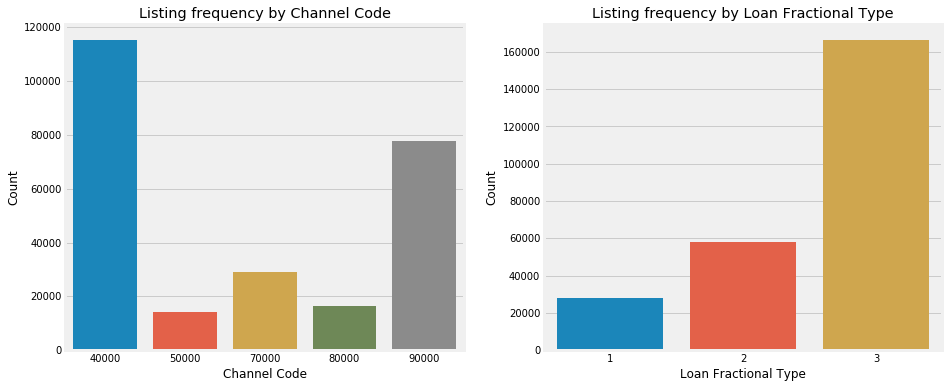

In [41]:
fig, ax= plt.subplots(1,2, figsize=(14,6))

sns.countplot(df['EnumChannelCode'], ax=ax[0])
ax[0].set(title='Listing frequency by Channel Code', ylabel='Count', xlabel='Channel Code')

sns.countplot(df['EnumLoanFractionalType'], ax=ax[1])
ax[1].set(title='Listing frequency by Loan Fractional Type', ylabel='Count', xlabel='Loan Fractional Type')

plt.show()

##### Channel Code

Let us first understand Channel Code. There are two kinds of acquisition methods for lending institutions to bring on borrowers – active and passive.  Passive acquisitions are borrowers who apply for credit without responding to a direct offer. Active methods include direct mail, telemarketing, emails, and online advertising.  Most lenders use a combination of active methods in order to acquire many of their borrowers. 
<br>
<br>
Currently, the Prosper data lists 5 different acquisition channels by the following codes:
40000, 50000, 70000, 80000, and 90000
<br>
<br>
Prosper API does not give any more information on these codes. It is difficult to know the difference between these codes, though some patterns do emerge. More than half the listings in the dataset belong to channel code 40000, which together with code 90000 account for over 75% of the listings.
<br>
<br>
Given that we don’t know what the channels mean, it is hard to draw much of a conclusion about the effects of Channel code on loan origination. Let's not risk removing this feature, and keep it. 
<br>
<br>
##### Loan Fractional Type
Loan fractional type comes in 3 categories, and I don't know what each type represents. I am going to keep this feature. 

##### Borrower State

Let us now focus on another category, state of address of the borrower. Let's see how many unique states are there in the dataset.

In [42]:
df.StrState.unique()

array(['VA', 'CA', 'MN', 'OK', 'AL', 'FL', 'NY', 'TN', 'MI', 'UT', 'OH',
       'TX', 'WI', 'AZ', 'GA', 'IL', 'NJ', 'WA', 'CO', 'KS', 'NC', 'MA',
       'LA', 'NV', 'IN', 'SC', 'ID', 'NM', 'CT', 'OR', 'KY', 'PA', 'RI',
       'NH', 'MD', 'HI', 'DC', 'VT', 'AK', 'MO', 'DE', 'WV', 'NE', 'MS',
       'AR', 'SD', 'MT', 'WY'], dtype=object)

We notice that there are 48 unique categories within this feature. This makes sense since Prosper does not allow lending in Iowa, Maine and North Dakota. 
<br>
<br>
My first instinct was to drop this variable altogether, because of its very broad levels. Intuitively, the state of borrower is an important variable since it affects monthly income (income taxes vary by state), property taxes (and this in turn affects real estate payment) and a combination of these might influence debt-to-income ratio. The FICO score presumably should also depend on state, and as such it stands to reason that the geographical location plays a subtle and an important role in influencing other features, and hence the chances of getting a loan originated. But, as mentioned before, there are 48 categories within this variable, and that might result in a marked increase in model complexity and time for training. 
<br>
<br>
To incorporate the effect of State on the eventual outcome, I engineered a new boolean feature `IsProsperScoreBetterThanMedian`. This is 1 if a borrower has a better than median Prosper score among all other borrowers grouped by state. I chose Prosper Score to engineer this feature since the Prosper score is specifically built on the Prosper borrower and applicant population, unlike a credit bureau score, which is based on a much wider variety of loan performance. Since Prosper uses both the custom score and the credit reporting agency score together to assess the borrower’s level of risk and determine estimated loss rates, I think Prosper score better incorporates the interaction of other features among themselves. For instance, Prosper score takes takes into account FICO score, whether the debtor owns a home, number of delinquencies, total balance on all of open revolving credit lines, debt-to-income ratio and number of inquiries made by creditors to in the last six months. And hence this new engineered feature considers both the state of the borrower and interactions between other feature, by means a simple binary encoding. 

In [43]:
median_prosper_score_by_state = df.groupby("StrState")[["ProsperScore"]].transform('median')["ProsperScore"]
df["IsProsperScoreBetterThanMedian"] = (df["ProsperScore"] > median_prosper_score_by_state).astype(int)

Let's now remove the State variable. 

In [44]:
df.drop(["StrState"], axis=1, inplace=True)

##### Listing Category

Let's now focus on the remaining categorical variable, Listing category. This feature is comprised of integers with each integer corresponding to a particular category as described in [Prosper API](https://developers.prosper.com/docs/investor/listings-api/).

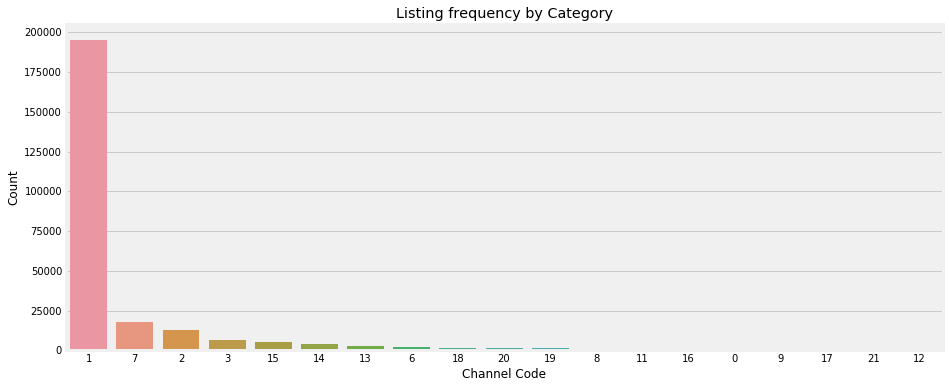

In [45]:
fig, ax= plt.subplots(figsize=(14,6))
sns.countplot(x = 'EnumListingCategory',
              data = df,
              order = df['EnumListingCategory'].value_counts().index)
ax.set(title='Listing frequency by Category', ylabel='Count', xlabel='Channel Code')
plt.show()

In [46]:
df['EnumListingCategory'].value_counts(normalize=True)

1     0.773818
7     0.070331
2     0.050058
3     0.024954
15    0.021211
14    0.016026
13    0.010766
6     0.008944
18    0.005874
20    0.005597
19    0.005335
8     0.001604
11    0.001319
16    0.001109
0     0.000903
9     0.000634
17    0.000578
21    0.000503
12    0.000436
Name: EnumListingCategory, dtype: float64

We notice that over 75% of the listings fall under Category 1, Debt consolidation followed by Category 7 (Other) and Category 2 (Home). These three categories together account for nearly 90 % of the observations, while the remaining 19 features together account for the remaining observations. There is a lot of granularity in this feature, and this might affect the algorithm training time. With that in mind, I decided to engineer a new feature `ListingCategory` with just 4 categories ('Debt', 'Other', 'Home', 'Remaining').

In [47]:
df.loc[df['EnumListingCategory'] == 1, 'ListingCategory'] = 'Debt'
df.loc[df['EnumListingCategory'] == 7, 'ListingCategory'] = 'Other'
df.loc[df['EnumListingCategory'] == 2, 'ListingCategory'] = 'Home'
df.loc[(df.EnumListingCategory != 1) & 
       (df.EnumListingCategory != 7) & 
       (df.EnumListingCategory != 2), 'ListingCategory'] = 'Remaining'

Let's now remove `EnumListingCategory`

In [48]:
df.drop(["EnumListingCategory"], axis=1, inplace=True)

Let us now analyze the remaining nominal variable, `StrEmploymentStatus`.

In [49]:
df.StrEmploymentStatus.value_counts()

Employed         216677
Other             19544
Self-employed     15621
Full-time           614
Part-time             5
Not employed          4
Name: StrEmploymentStatus, dtype: int64

This feature looks very promising and has only a few levels. Let's not modify it and keep it as is. 

Before we move on to deploying classfication algorithms, let us encode our labels as True/ False. True corresponds to a loan being canceled.

In [50]:
df.EnumListingStatus = df.EnumListingStatus - 6

We have gotten rid of most of the variables which won't be helpful to the analysis, engineered new features which might be helpful and also made sure that all missing values have been dealt with. The remaining features look promising, and we will keep them. 
<br>
<br>
Let us remark that feature dropping and engineering were done by intuitively understanding which features might hold predictive power. At no point did we peek at the labels to make a decision, as that would bias the algorithm and likely result in overfitting. (We can't look at the full dataset labels to do supervised feature selection. Either we split the data in to training and testing sets, look at the training set labels, perform feature selection and use those same features for test set. Or we perform an unsupervised feature selection.)


### Feature selection & Dimensionality Reduction <a id='dimensionality_reduction'></a>

Feature selection is critical to building a good model for several reasons. One is that feature selection implies some degree of cardinality reduction, to impose a cutoff on the number of attributes that can be considered when building a model. This can help in mitigating overfitting by selecting only the most important attributes, reduce training time and result in better model interpretability.  Selecting the most important predictive features from a large space can be tricky.
<br>
<br>

For any given data set, there are a host of supervised and unsupervised feature selection and dimensionality reduction techniques one can use. Filter, Wrapper and Embedded Methods allow us to perform supervised feature selection while PCA is a common example of unsupervised feature selection. 
<br>
<br>
Filter Methods consider the relationship between features and the target variable to compute the importance of features. Within filter methods, we can use F-test and Variance threshold (which is actually an unsupervised technique) to select a subset of best features. I ruled out Variance threshold since it removes features with variation below a certain cut-off. This might remove features which are ordinal or categorical, since such features don't vary much. Our dataset has a lot of categorical and ordinal features, and it will be risky to remove them using a technique which looks for variation among variables and does not peek into the labels.  F-Test is useful in feature selection as we get to know the significance of each feature in improving the model. F-Test checks for and only captures linear relationships between features and labels. A highly correlated feature is given higher score and less correlated features are given lower score. Using summary statistics like correlation may be a bad idea, as illustrated by Anscombe’s quartet. I decided not to use F-test for feature selection. Mutual info classification could be a promising way to perform feature selection since it does well with non-linear reltionship between feature and label. This function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances. But, ultimately it is a form of univariate feature selection and I feel like that might not be appropriate for this dataset which has dependencies among features. 
<br>
<br>
Wrapper Methods generate models with a subsets of feature and gauge their model performances. However, the main drawbacks of wrapper methods is the sheer amount of models that needs to be trained. It can be computationally very expensive and decided not to use them. 
<br>
<br>
PCA is a form of unsupervised feature selection technique, which tries to minimize variance. The correlation of features with each Principle Component has nothing to do with the dependent variable. Technically, one can use PCA on categorical data (e.g. one-hot encoded data), but that would not be the correct approach.  The PCA finds the directions of highest variance and makes Gaussian assumptions about the data via its use of the covariance matrix. Using PCA for the given dataset is not meaningful. 
<br>
<br>
I feel that feature selection using Embedded methods would be the best approach here. They perform variable selection as part of the learning procedure. The given dataset has a lot of features that are closely (linearly and non-linearly) related to each other. 
<br>
<br>
For instance, debt-to-income ratio is related to monthly debt and income; Prosper principal balance outstanding and outstanding loan balance are linearly related to each other; Prosper score takes takes into account FICO score, whether the debtor owns a home, number of delinquencies, total balance on all of open revolving credit lines, debt-to-income ratio and number of inquiries made by creditors to in the last six months and is thus related to all these variables. With this in mind, I decided to use two feature selection techniques- one which incorporates linear relationship among the features and other which uses tree-based strategies to rank how each feature improves the purity of a node. 
<br>
<br>
#### Encoding

First we need to convert our categorical features in to numerical features, since scikit-learn's classification algorithms require numerical features. We could use either integer encoding or one-hot encoding to convert our categorical data to numerical data. For ordinal features like `CreditGrade`, integer encoding makes sense as there is a natural order among the feature categories. I used an encoding which places a higher number of less risky grade, similar to what `ProsperScore` does. 
<br>
<br>
For categorical variables where no such ordinal relationship exists, the integer encoding is not enough. In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results. For such variables, we will use one-hot encoding.

In [51]:
categorical_vars = ['ListingCategory', 'StrEmploymentStatus', 'EnumChannelCode', 'EnumLoanFractionalType']
df = pd.get_dummies(df, columns=categorical_vars)
df.replace(to_replace={"CreditGrade": {"AA": 7, "A": 6, "B": 5, "C": 4, 
                                       "D": 3, "E": 2, "HR": 1}}, inplace=True)

### Training, validation & testing <a id='training'></a>

We now randomly split our data in to training and testing sets. We will use the training set to train and validate our models and the independent test set to assess the classifier's performance. We split the data in a stratified fashion to make sure that the random split has similar proportion of class labels (in train and test sets) as in the full data-set.

In [52]:
features = df.drop("EnumListingStatus", axis=1)
labels = df["EnumListingStatus"]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.1, 
                                                                            random_state=42,
                                                                            stratify=labels) 

Instead of k-fold cross validation, we will use Stratified split for validation. Stratification seeks to ensure that each fold is representative of all strata of the data. Generally this is done in a supervised way for classification and aims to ensure each class is (approximately) equally represented across each test fold (which are of course combined in a complementary way to form training folds). Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. To counter the imbalance in our labels, we will use a technique called Stratified Shuffle Split for validating our model. 


In [53]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42) # 5 splits with 80-20 split

Feature selection and classification algorithms which depend on a notion of distance (SVM, regularized logistic regression, k-nearest neighbors) require scaling, while  tree-based algorithms (decision trees and random forests) are not affected by scaling. In such cases, not only is scaling not necessary, it can smooth out the nonlinear nature of the model.
<br>
<br>
My broad line of attack for this problem is to consider two different types of feature selection and classification algorithms. We will consider two different sets of training/ testing data for each of these techniques. 
<br>
<br>
#### Linear Classifers

Let's start with linear classifers, which depend on notion of a distance. For such classifiers, it is important to normalize the features before performing feature selection. Instead of standardaizing with 0 mean and unit variance, we will rescale the data so that all features lie in [0, 1]. Another advantage of re-scaling over standardization is that re-scaling leaves boolean variables intact.

In [54]:
scaler = MinMaxScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

##### Elastic net feature selection

Since a lot of our features have a linear dependence, it might be tempting to use LASSO for feature selection. (Let us remark that one-hot encoding results in a perfect linear relationship between the categories of the feature, since all of them sum to 1). If we just use LASSO it tends to select only one predictor among the predictors that are highly correlated. This can be a problem when one wants to validate the selected variables in an independent dataset. The variable selected by LASSO may not be the best predictor among all correlated variables. Elastic Net solves this problem by averaging highly correlated variables.

We wil use log-loss objective with elastic net penalty (with default parameters) to perform feature selection. 

In [55]:
sgd = SelectFromModel(SGDClassifier(loss = 'log', penalty='elasticnet'), 
                                    threshold='mean')

sgd.fit(features_train_scaled, labels_train)

SelectFromModel(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='mean')

In [56]:
sgd.estimator_.coef_

array([[-0.54461214, -0.05900021,  0.26978167, -8.00117199,  6.79601518,
         0.33551465,  1.61816673,  0.20982623, -0.18851479,  0.50262672,
         0.33735381, -0.30469346, -0.18889393, -0.1046516 , -0.11743976,
        -0.26169993, -0.17577155, -0.16642085,  0.22461262,  0.17839454,
         0.        ,  0.        , -0.44239839, -0.21019729,  0.06056618,
         0.02697156,  0.72551085, -0.44549883,  0.43999438,  0.4201962 ,
         0.43985456, -0.32428085, -0.08917403,  0.        , -0.08639017,
        -0.09885353,  0.34530659,  0.52426843,  1.07379058, -1.00187319,
        -0.20108289, -0.2840898 ,  0.56134993, -0.29368902, -1.79184292,
         0.        , -0.1711678 , -0.22248524,  0.        , -0.27611552,
         0.9982735 ,  0.        , -0.87739207, -1.2519494 , -1.22460037,
         1.89707306,  0.        ,  0.27460202,  0.        ,  0.49496261,
        -0.34412489,  0.        , -0.41164785, -0.32231677, -0.05364643,
        -0.13986862, -0.20289695,  0.        ,  0. 

In [57]:
mask = sgd.get_support()
selected_features = [] 

for bool, feature in zip(mask, df.columns):
    if bool:
        selected_features.append(feature)
selected_features
#len(selected_features)

['EnumListingStatus',
 'CreditGrade',
 'LenderYield',
 'NumMonthsTerm',
 'ProsperScore',
 'BoolIsLender',
 'PctTradesNeverDelinquent',
 'NumBankcardTradesOpened12',
 'DolTotalAvailBankcardCredit6',
 'NumRealPropertyTrades',
 'NumTradesEverDerog',
 'NumCreditLines84',
 'DolAmountDelinquent',
 'NumCurrentCreditLines',
 'NumOpenCreditLines',
 'PctBankcardUtil',
 'DolRealEstatePayment',
 'StrEmploymentStatus_Not employed',
 'EnumChannelCode_70000']

Logistic Regression with Elastic Net peanlty has only chosen features whose estimated co-efficients are above the mean. 
Elastic net seems to have done a good job of filtering out most of linearly dependent features, especially those features which were one-hot encoded, and hence had a perfect linear relationship. Within the selected features, there is a mix of boolean, ordinal and numerical variables. 
<br>
<br>
Our eventual models will use only these features. Let us transform our train and test data sets so that they include only these features.

In [58]:
features_reduce_train_scaled = sgd.transform(features_train_scaled)
features_reduce_test_scaled = sgd.transform(features_test_scaled)

##### SVC & Passive Aggressive Classifier 

We will now use two linear classifiers on the transformed data set.

*A small note on cross-validation and workflow*
<br>
<br>
In sklearn, the `GridSearchCV` class is a convenient way of pulling off  parameter selection. When fed training data, it will perform multiple training-validation splits and fit a selected algorithm or pipeline to these splits, selecting a parameter set that has the best overall performance on the validation sets. 
<br>
<br>
By default, `GridSearchCV` performs 3-fold cross-validation, but we can also set different cross-validation or scoring functions. We will use roc-auc as scoring function for the validation step. We will use the previously created `StratifiedShuffleSplit`  object as the cross-validation function. When we use `GridSearchCV`, the validation is performed internally. We don't use a test/train split to validate our model. The optimal model is selected by GridSearchCV based on the internal train/validation subsets that it creates automatically.
<br>
<br>
We will also use the `Pipeline` module of scikit-learn which allows one to chain transformers and estimators together in such a way that one can use them as a single unit. Python scikit-learn provides a Pipeline utility to help automate machine learning workflows.Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated. The goal is to ensure that all of the steps in the pipeline are constrained to the data available for the evaluation, such as the training dataset or each fold of the cross validation procedure.

###### Support Vector Classifier 

Let's consider Support vector classifer with a liner kernel and hinge loss (which penalizes misclassifications) with l2 regularizaltion. We will consider a regularization parameter C, which controls the trade-off between achieving a low error on the training data and minimising the norm of the weights. 

In [59]:
t0 = time.time()
pipeline_svc = Pipeline([
  ('classification', LinearSVC(dual=False, class_weight='balanced', random_state=42))
])

param_grid_svc = [
    {
        'classification__C' : [0.1, 1, 10, 100, 1000]    
    }
]
gs_svc = GridSearchCV(pipeline_svc, 
                      param_grid=param_grid_svc, 
                      scoring='roc_auc', 
                      cv=sss)
print("\nPerforming grid search for Support vector classifier over hyperparameters...")
gs_svc.fit(features_reduce_train_scaled, labels_train)
t1 = time.time()


Performing grid search for Support vector classifier over hyperparameters...


In [60]:
svc_time = t1 - t0 
gs_svc.best_estimator_ # This is the model with the best mean ROC-AUC score

Pipeline(memory=None,
     steps=[('classification', LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))])

In [61]:
gs_svc.best_score_ # This is the best mean ROC-AUC score

0.6634868853297711

In [62]:
fpr_svc, tpr_svc,_= roc_curve(gs_svc.best_estimator_.predict(features_reduce_test_scaled),
                                                            labels_test,drop_intermediate=False)
roc_svc = roc_auc_score(gs_svc.best_estimator_.predict(features_reduce_test_scaled), labels_test)

######  Passive Aggressive Classifier 

Let's consider another classification with hinge loss function. Here C is a positive parameter which controls the influence of the slack term on the objective function. Specifically, larger values of C imply a more aggressive update step and we
therefore refer to C as the aggressiveness parameter of the algorithm. This is an example of online binary classification, which takes place in a sequence of rounds. On each round the algorithm observes an instance and predicts its label. After the
prediction is made, the true label is revealed and the algorithm suffers an instantaneous loss which
reflects the degree to which its prediction was wrong. At the end of each round, the algorithm uses
the newly obtained instance-label pair to improve its prediction rule for the rounds to come. 

In [63]:
t0 = time.time()
pipeline_pac = Pipeline([
  ('classification', PassiveAggressiveClassifier(class_weight='balanced', 
                                                 n_jobs=-1,
                                                 random_state=42))
])

param_grid_pac = [
    {
        'classification__C' : [0.1, 1, 10, 100, 1000]    
    }
]
gs_pac = GridSearchCV(pipeline_pac, 
                      param_grid=param_grid_pac, 
                      scoring='roc_auc', 
                      cv=sss)
print("\nPerforming grid search for Passive Aggressive classifier over hyperparameters...")
gs_pac.fit(features_reduce_train_scaled, labels_train)
t1 = time.time()


Performing grid search for Passive Aggressive classifier over hyperparameters...


In [64]:
pac_time = t1 - t0 
gs_pac.best_estimator_

Pipeline(memory=None,
     steps=[('classification', PassiveAggressiveClassifier(C=0.1, average=False, class_weight='balanced',
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=-1, random_state=42, shuffle=True, tol=None,
              verbose=0, warm_start=False))])

In [65]:
fpr_pac, tpr_pac,_= roc_curve(gs_pac.best_estimator_.predict(features_reduce_test_scaled),
                                                            labels_test,drop_intermediate=False)

roc_pac = roc_auc_score(gs_pac.best_estimator_.predict(features_reduce_test_scaled), labels_test)

#### Ensemble methods

##### Random Forest feature selection

As an alternative to linear feature selection, let's use a random forest for variable selection. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset. Compared with single decision trees, random forests split by selecting multiple feature variables instead of single features variables at each split point. Intuitively, the variable selection properties of decision trees can be drastically improved using bagging procedure, as used in random forests. 

In [66]:
rfc = RandomForestClassifier(n_estimators=50, random_state=42) # Use a relatively large number of trees
rfc = rfc.fit(features_train , labels_train)

In [67]:
rfc.feature_importances_  

array([2.52211455e-02, 9.44040942e-04, 9.31687824e-03, 8.89046175e-02,
       2.71478457e-02, 4.05127679e-03, 3.87401068e-02, 1.39152612e-02,
       1.60399677e-02, 3.66547600e-02, 2.75558244e-03, 3.25913838e-02,
       3.47804830e-02, 7.91067334e-05, 1.23069931e-03, 2.79837115e-03,
       8.02282223e-04, 1.27951118e-03, 2.16358097e-03, 1.53614750e-03,
       1.59779821e-04, 3.13777112e-05, 3.38511557e-03, 2.33693325e-03,
       3.87263263e-04, 5.76395031e-04, 2.17920777e-02, 9.72978181e-03,
       1.75553539e-03, 3.82351830e-04, 1.83553968e-03, 7.18333062e-03,
       2.98915963e-02, 2.15359700e-03, 2.99335008e-02, 8.06924204e-03,
       1.37621050e-02, 1.59282980e-02, 3.27754726e-02, 2.78908334e-02,
       9.24154294e-03, 1.13886322e-02, 2.88578860e-02, 6.69352100e-03,
       3.07826492e-02, 3.77333824e-03, 8.56428665e-03, 4.37836809e-03,
       2.73037373e-04, 2.17892751e-02, 9.87079171e-03, 5.53473236e-03,
       1.78459713e-02, 1.73637741e-02, 2.73322463e-02, 1.80542958e-02,
      

In [68]:
importances = list(zip(rfc.feature_importances_, features_train.columns))
importances.sort(reverse=True)
importances # Lisit of features in descending order of importance as measured by the mean decrease accuracy

[(0.0889046174701757, 'LenderYield'),
 (0.038740106780220905, 'DolMonthlyLoanPayment'),
 (0.03665475996888341, 'DolMonthlyIncome'),
 (0.03478048296938041, 'NumMonthsEmployed'),
 (0.03277547257054183, 'DolTotalAvailBankcardCredit6'),
 (0.0325913838204551, 'FracDebtToIncomeRatio'),
 (0.0315768509050936, 'MonthsWithCredit'),
 (0.030782649185991426, 'DolMonthlyDebt'),
 (0.02993350084536284, 'DolTotalPaymentAllOpenTrades6'),
 (0.029891596293873914, 'DolTotalBalanceAllOpenTrades6'),
 (0.02908465636148473, 'DolRevolvingBalance'),
 (0.028857885979549556, 'DolTotalBalanceOpenRevolving6'),
 (0.027890833424608043, 'DolTotalBalanceInstallTradesReptd6'),
 (0.027332246279375024, 'PctBankcardUtil'),
 (0.027147845701623874, 'BorrowerRate'),
 (0.025221145510408893, 'DolLoanAmountRequested'),
 (0.021792077685755883, 'NumTrades'),
 (0.021789275145309494, 'NumCreditLines84'),
 (0.021516842747936516, 'NumSatisfactoryAccounts'),
 (0.019742402657389344, 'NumTotalInquiries'),
 (0.018054295819873722, 'NumOpenR

In [69]:
# Choose the top 20 features. This is an arbitrary cut-off. I just wanted to ensure that we work
# with the same number of features as in the elastic net feature selection.
top_20_features = []
for i in importances[:20]:
    top_20_features.append(i[1])

Let's compare the features selected by the Elastic net model and the random forest classifier.

In [70]:
set(top_20_features).intersection(selected_features)

{'DolTotalAvailBankcardCredit6',
 'LenderYield',
 'NumCreditLines84',
 'PctBankcardUtil'}

There is significant lack of overlap in the selected features. Since we are using different criteria (collinearity vs mean decrease accuracy) to select features, it is not too much of a surprise that selected features differ. However, this calls for greater scruity (and possible future work!) in the way we select variables. 

In [71]:
features_reduced_train = features_train[top_20_features]
features_reduced_test = features_test[top_20_features]

###### Adaboost classifier

Boosting is a general ensemble method that creates a strong classifier from a number of weak classifiers (a classifier whose error rate is slightly better than random). This is done by building a model from the training data, then creating a second model that attempts to correct the errors from the first model. Models are added until the training set is predicted perfectly or a maximum number of models are added. The purpose of boosting us to sequentially apply the weak classification algorithm to repeatedly modified versions of the data, thereby producing a sequence of weak classifiers. The predictions from all of them are then combined through a weighted majority vote to produce the final prediction. 
<br>
<br>
Boosting is a way of fitting an additive expansion in a set of elementary basis functions. We will use Adaboost which fits an additive model in a base learner using an exponential loss function. 

In [72]:
t0 = time.time()
pipeline_adb = Pipeline([
    ('classify', AdaBoostClassifier(random_state=42))
])
param_grid_adb = [
    { 
        'classify__n_estimators': [50, 60, 70, 80],
    }
]
gs_adb = GridSearchCV(pipeline_adb, 
                     param_grid=param_grid_adb, 
                     scoring='roc_auc',
                     cv=sss,
                     n_jobs=-1)
print("\nPerforming grid search for Adaboost classifier over hyperparameters...")
gs_adb.fit(features_reduced_train, labels_train)
t1 = time.time()


Performing grid search for Adaboost classifier over hyperparameters...


In [73]:
adb_time = t1 - t0 
gs_adb.best_estimator_

Pipeline(memory=None,
     steps=[('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=80, random_state=42))])

In [74]:
fpr_adb, tpr_adb, _ = roc_curve(gs_adb.best_estimator_.predict(features_reduced_test),
                                                               labels_test, drop_intermediate=False)

roc_adb = roc_auc_score(gs_adb.best_estimator_.predict(features_reduced_test), labels_test)

###### Gradient Boosting 

AdaBoost analytically minimizes exponential loss. Exponential loss is sensitive to outliers and misclassified points. The “binomial deviance” loss function is better behaved. (Both exponential and binomila deviance loss can be veiwed as a monotone continuous approximations to misclassification loss). Gradient boosting is a technique which numerically boosts trees for binomial deviance.

In [75]:
t0 = time.time()
pipeline_gdb = Pipeline([
    ('classify', GradientBoostingClassifier(random_state=42))
])
param_grid_gdb = [
    { 
        'classify__learning_rate': [0.001, 0.01, 0.1],
    }
]
gs_gdb = GridSearchCV(pipeline_adb, 
                     param_grid=param_grid_gdb, 
                     scoring='roc_auc',
                     cv=sss,
                     n_jobs=-1)
print("\nPerforming grid search for Gradient boost classifier over hyperparameters...")
gs_gdb.fit(features_reduced_train, labels_train)
t1 = time.time()


Performing grid search for Gradient boost classifier over hyperparameters...


In [76]:
gdb_time = t1 - t0 
gs_gdb.best_estimator_

Pipeline(memory=None,
     steps=[('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=42))])

In [77]:
fpr_gdb, tpr_gdb, _ = roc_curve(gs_gdb.best_estimator_.predict(features_reduced_test),
                                                               labels_test, drop_intermediate=False)

roc_gdb = roc_auc_score(gs_gdb.best_estimator_.predict(features_reduced_test), labels_test)

#### Performance comparison <a id='performance'></a>

Let us compare the performace of the various classifiers. Let us start by plotting the ROC-AUC curve.

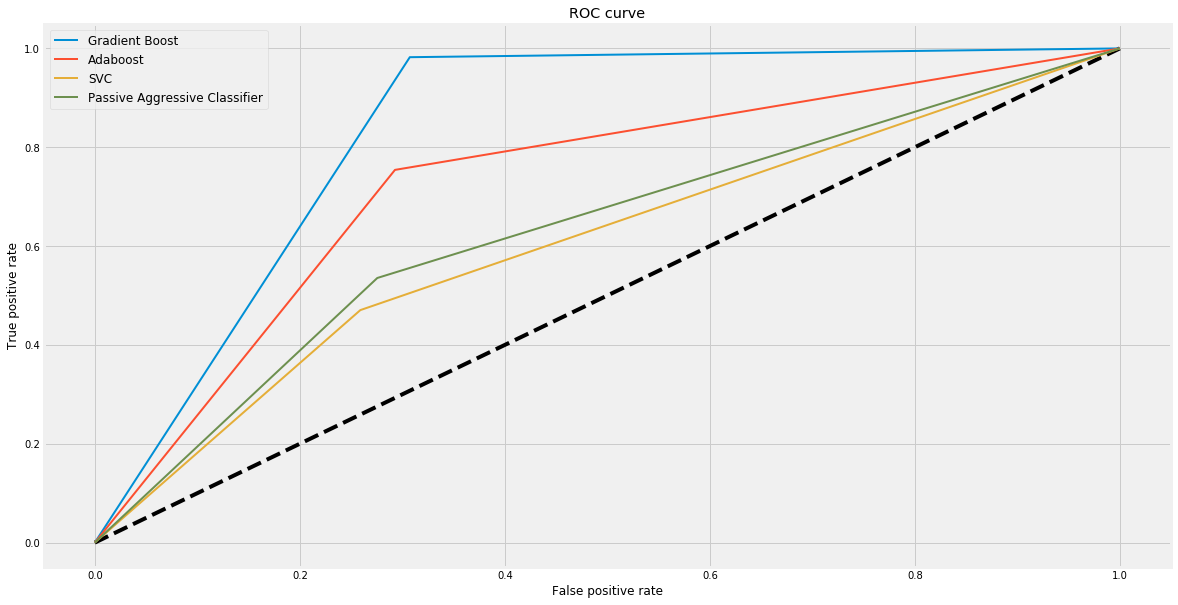

In [78]:
plt.figure(figsize=(18, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gdb, tpr_gdb, linewidth=2, label='Gradient Boost')
plt.plot(fpr_adb, tpr_adb, linewidth=2, label='Adaboost')
plt.plot(fpr_svc, tpr_svc, linewidth=2, label='SVC')
plt.plot(fpr_pac, tpr_pac, linewidth=2, label='Passive Aggressive Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best', fontsize = 'large')
plt.show()

If we want to measure  more abstract measures(like precision, recall or f1 score), we could get those measures by using classification_report function under the metrics submodule.

In [79]:
print('Linear SVC:\n {}\n'.format(classification_report(labels_test, 
                                                        gs_svc.best_estimator_.predict(features_reduce_test_scaled))))
print('Passive Aggressive Classifier:\n {}\n'.format(classification_report(labels_test,
                                                                           gs_pac.best_estimator_.predict(
                                                                               features_reduce_test_scaled))))

print('Adaboost Classifier:\n {}\n'.format(classification_report(labels_test,
                                                                 gs_adb.best_estimator_.predict(features_reduced_test))))
print('Gradient boost Classifier:\n {}\n'.format(classification_report(labels_test,
                                                                       gs_gdb.best_estimator_.predict(features_reduced_test))))

Linear SVC:
              precision    recall  f1-score   support

          0       0.74      0.72      0.73     16805
          1       0.47      0.50      0.49      8442

avg / total       0.65      0.64      0.65     25247


Passive Aggressive Classifier:
              precision    recall  f1-score   support

          0       0.72      0.84      0.78     16805
          1       0.54      0.36      0.43      8442

avg / total       0.66      0.68      0.66     25247


Adaboost Classifier:
              precision    recall  f1-score   support

          0       0.71      0.97      0.82     16805
          1       0.75      0.20      0.32      8442

avg / total       0.72      0.71      0.65     25247


Gradient boost Classifier:
              precision    recall  f1-score   support

          0       0.69      1.00      0.82     16805
          1       0.98      0.12      0.21      8442

avg / total       0.79      0.70      0.61     25247




In [80]:
roc_auc_df = pd.DataFrame([
                          ['SVC', roc_svc, svc_time],
                          ['Passive Agressive classifer', roc_pac, pac_time],
                          ['Adaboost', roc_adb, adb_time],
                          ['Gradient boost', roc_gdb, gdb_time]
                         ], 
                         columns=['Classifier', 'Test ROC AUC', 'Training time'])

In [81]:
roc_auc_df

,Classifier,Test ROC AUC,Training time
0,SVC,0.605703,213.230044
1,Passive Agressive classifer,0.629932,17.736126
2,Adaboost,0.730678,273.600833
3,Gradient boost,0.837468,148.763626


Of all the classifiers, Gradient boost with random forest feature selection gives us the best test performance metric (roc-auc). It significantly outperforms other classfication algorithms with respect to this metric. 
<br>
<br>
The goal of this exercise to classify as many correct instances of canceled loans so that the cash drag is minimized. (As an investor, we also need to correctly identify the loans which will eventually be originated). Since our original data is skewed in favor of originated loans (thereby causing an imbalance in class labels), let us also look at precision and recall of the classifiers. 
<br>
<br>
Within the class of canceled loans (label 1), the ensemble classfiers have a very poor recall (percentage of class 1 labels that were correctly identified) and near perfect precision (percentage of positive predictions that were correct).  The roc-auc for these ensemble methods is high (perhaps misleadingly so), and if the sole goal is to identify the eventually canceled loan, these classifiers perform poorly. (I also think that for our dataset, which has skewed class labels, and for purposes of identifying canceled loans, roc-auc metric is not the correct metric. Recall, which identifies percentage of class labels that were correctly identified is a more appropriate metric. But, seeing that minimizing cash drag is not the sole goal for an investor and that they also need to identify the 'right' loans, roc-auc might indeed be a better metric!)
<br>
<br>
Both the linear classifiers have a low roc-auc. But within the class of canceled loans, these classifiers significantly outperform the ensemble classifiers with respect to recall.

#### Conclusion <a id='conclusion'></a>

Let's wrap things up. I'm pretty happy with this project. Our recall isn't good, and certainly needs more work. There are a few things that can be tried to improve the predictive performance. I list some of them here.
<br>
1. More work needs to be done in the data pre-processing part. A lot of decisions with respect to keeping or throwing variables were attrbuted to intuition or common logic. Seeing that the actual goal is to mimic Prosper's model, a more structured approach needs to be taken with regards to how features interact among themselves and how different features are calculated by Prosper. 
<br>
<br>
2. Seeing that there were groups of closely related variables, perhaps a grouped lasso feature selection might work better. The lasso solution is not satisfactory as it only selects individual dummy variables instead of whole factors. Moreover, the lasso solution depends on how the dummy variables are encoded. Choosing different contrasts for a categorical predictor will produce different solutions in general. Grouped lasso has the attractive property that it does variable selection at the group level.
<br>
<br>
3. We performed one-hot encoding for our categorical features. Decision tree models can handle categorical variables without one-hot encoding them. However, popular implementations of decision trees (and random forests) differ as to whether they honor this fact. (sklearn pre-supposed one-hot encoding). One-hot encoding also presents two problems that are more particular to tree-based models:
<br>
<br>
  (a) The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
    
   (b) A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance. One can try using h2o library in python, which does not presuppose one-hot encoding, for tree based methods. 
<br>
<br>
4. Validate over a larger grid of hyper-parameters to get a better performing model. This increases the training time, so some work also can be done on ways to parallelize the computations. 
